# Aprendizagem Automática 2022/2023
## Second Home Assignment

### Team
- Ana Araújo
- Francisco Frazão
- Pedro Almeida

#### Content Table
- [1. Data Preprocessing](#section1)
 - [1.1 Scaling](#section2)
 - [1.2 Missing Values](#section3)
 - [1.3 Variable Transformation](#section4)
 - [1.4 Feature Selection](#section5)
- [2. Best Classifier](#section6)
- [3. Discussion of Results](#section7)


**Introduction:**
The aim of this project is to provide the best possible classification models using whatever method covered in Machine Learning class:
- The variable to Classify is Biodegradable
- Models should examine different hyperparameters and select the best one
- Simple Cross Validation (testing=25% of all data) for evaluating the models, but the same data partitions must be used for all models
- Identify the most significant features


**Import Libraries:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, mutual_info_regression, SelectFromModel, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, GradientBoostingRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import confusion_matrix, accuracy_score

**Data Importation:**

In [2]:
df = pd.read_csv('biodegradable_a.csv')
df['Biodegradable'] = df['Biodegradable'].replace(['RB', 'NRB'], [1, 0])
y = df['Biodegradable']
X = df.drop(columns=['Biodegradable'])

### WARNING!
Before scaling and imputing values we need to separate the dataset into training and testing because if we scaled the full data we would be implicitly learning the mean of the testing set thus having bias results.The same happens with the imputation. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

<a id='section1'></a>
## 1. Data Preprocessing

Data needs to be transformed and filtered for posterior processing. For that, we proceeded as follows:


<a id='section2'></a>
### 1.1 Scalling 
Many modeling approaches require some uniformity in the independent variables. Some datasets have outliers that may totally disrupt model results. Sometimes, the raw data only makes sense if properly scaled.


The scaling parameters must be fit only with the training data, which can be a problem in many test-validate approaches.


We fit the scaler with X_train and after we get the statistics we scale/transform X_test.


In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled =scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<a id='section3'></a>
### 1.2 Missing Values 
There are 3675 rows with missing values, so there are only 889 complete rows.\
There are 13 columns with missing values.\
Since the number of completed rows are much smaller, erasing incomplete columns or rows would lead us to a significant loss of information.
For that reason, the imputation data was considered.

In [5]:
n_miss_col= len([i for i in df.isnull().sum() if i>0])
n_miss_row= len([i for i in df.isnull().sum(axis=1) if i>0])
print(f'There are {n_miss_col} columns with missing values')
print(f'There are {n_miss_row} rows with missing values')

name_miss_col=[col for col in df.columns if df[col].isnull().any()]

There are 13 columns with missing values
There are 3675 rows with missing values


### 1.2.1 Imputation
Due to the fact that some algorithms cannot process data with missing values, we imputed before feature selection.
Because simpler methods like imputation by the average or median tend to have a higher influence on the statistics, we choose to execute the imputation based on the nearest neighbors. We fitted the imputer with the training data, which had already been scaled, and then applied to the test set, just as we did when scaling data.  The strategy is to estimate using similar data with known values. Because KNN imputation had a less impact, we decided to utilize it. To avoid the imputed data's potential impact on the scaling, we only performed the imputation after the scaling.
#### !We may need to perform substitution with a constant to evaluate statistics!

In [6]:
imputer = KNNImputer()
imputer.fit(X_train_scaled)
X_train_scaled_imputed = pd.DataFrame(imputer.transform(X_train_scaled))
X_test_scaled_imputed = pd.DataFrame(imputer.transform(X_test_scaled))

In [7]:
#Check to see if the imputation resulted, to be deleted later
X_train_scaled_imputed.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
dtype: int64

#### Description of columns that are missing values
- F01[N-N]: Frequency of N-N at topological distance 1
- C%: Percentage of C atoms
- nCp: Number of terminal primary C(sp3)
- HyWi_B(m): Hyper-Wiener-like index (log function) from Burden matrix weighted by mass
- F03[C-N]: Frequency of C-N at topological distance 3
- Me: Mean atomic Sanderson electronegativity (scaled on Carbon atom)
- nCIR: Number of circuits
- SpMax_B(m): Leading eigenvalue from Burden matrix weighted by mass
- SdO: Sum of dO E-states
- nCrt: Number of ring tertiary C(sp3)
- SpMax_B(m): Leading eigenvalue from Burden matrix weighted by mass
- Psi_i_A: Intrinsic state pseudoconnectivity index - type S average
- nX: Number of halogen atoms

To be fair and be able to do a direct comparison we’ve established a limit of 5 features for all methods. But before that we had to solve the problem of having different  data types.

<a id='section4'></a>
### 1.3 Transform Variables
After the data imputation, we proceeded to transform continuous variables into categorical ones.
For that we observed the unique values per column in order to see which variables are categorical and which variables are not.
Then, we categorize discrete data, which contain values that fall under integers or whole numbers. The discrete data are countable and have finite values; their subdivision is not possible.

### 1.3.1 Unique values per column 
Help to see what variables are categorical and what are continuous 

In [8]:
X_train_scaled_imputed.nunique()

0     2820
1     3396
2       11
3        6
4       16
5       12
6       14
7     2201
8       60
9       12
10      20
11    1945
12    3138
13    2673
14    2896
15      41
16    2539
17    2135
18       2
19       4
20       4
21    2889
22      36
23       2
24       2
25       4
26    2791
27    2230
28       2
29    2023
30    2952
31      13
32      11
33      16
34       8
35    3168
36    3087
37       8
38    3281
39       4
40      34
dtype: int64

### 1.3.2 Categorize Discrete Data

In [9]:
X_train_cat = X_train_scaled_imputed.copy()
X_test_cat = X_test_scaled_imputed.copy()

X_columns = [col for col in X.columns]
X_train_cat.columns = X_columns
X_test_cat.columns = X_columns
# para estas features basta mudar a coluna/Series para tipo category
excluded = ['F03','nHM','F01','F04','NssssC','nCb','nO','nN_N','nArNO2','nCRX3','B01','B03','N_073','B04','nCrt','C_026','F02_CN','nHDon','nN','nArCOOR','nX']
for i in X_train_cat:
    if i in excluded:
        X_train_cat[i] = X_train_cat[i].astype("category")
    else:
        X_train_cat[i] = pd.qcut(X_train_cat[i],3, labels=False,  duplicates="drop")
        
for i in X_test_cat:
    if i in excluded:
        X_test_cat[i] = X_test_cat[i].astype("category")
    else:
        X_test_cat[i] = pd.qcut(X_test_cat[i],3, labels=False,  duplicates="drop")


<a id='section5'></a>
### 1.4 Feature Selection

Feature selection is the method of reducing the input variable to your model by using only relevant data and getting rid of noise in data.

In [10]:
y_train=np.array(y_train)
N,M=X_train_cat.shape
N,M
v=np.hstack((y_train.reshape((N,1)), X_train))
d=pd.DataFrame(v, columns=[col for col in df.columns])

There is a correlation between F01,nCb,Mi,SpPosA_B with dependent variable Biodegradable

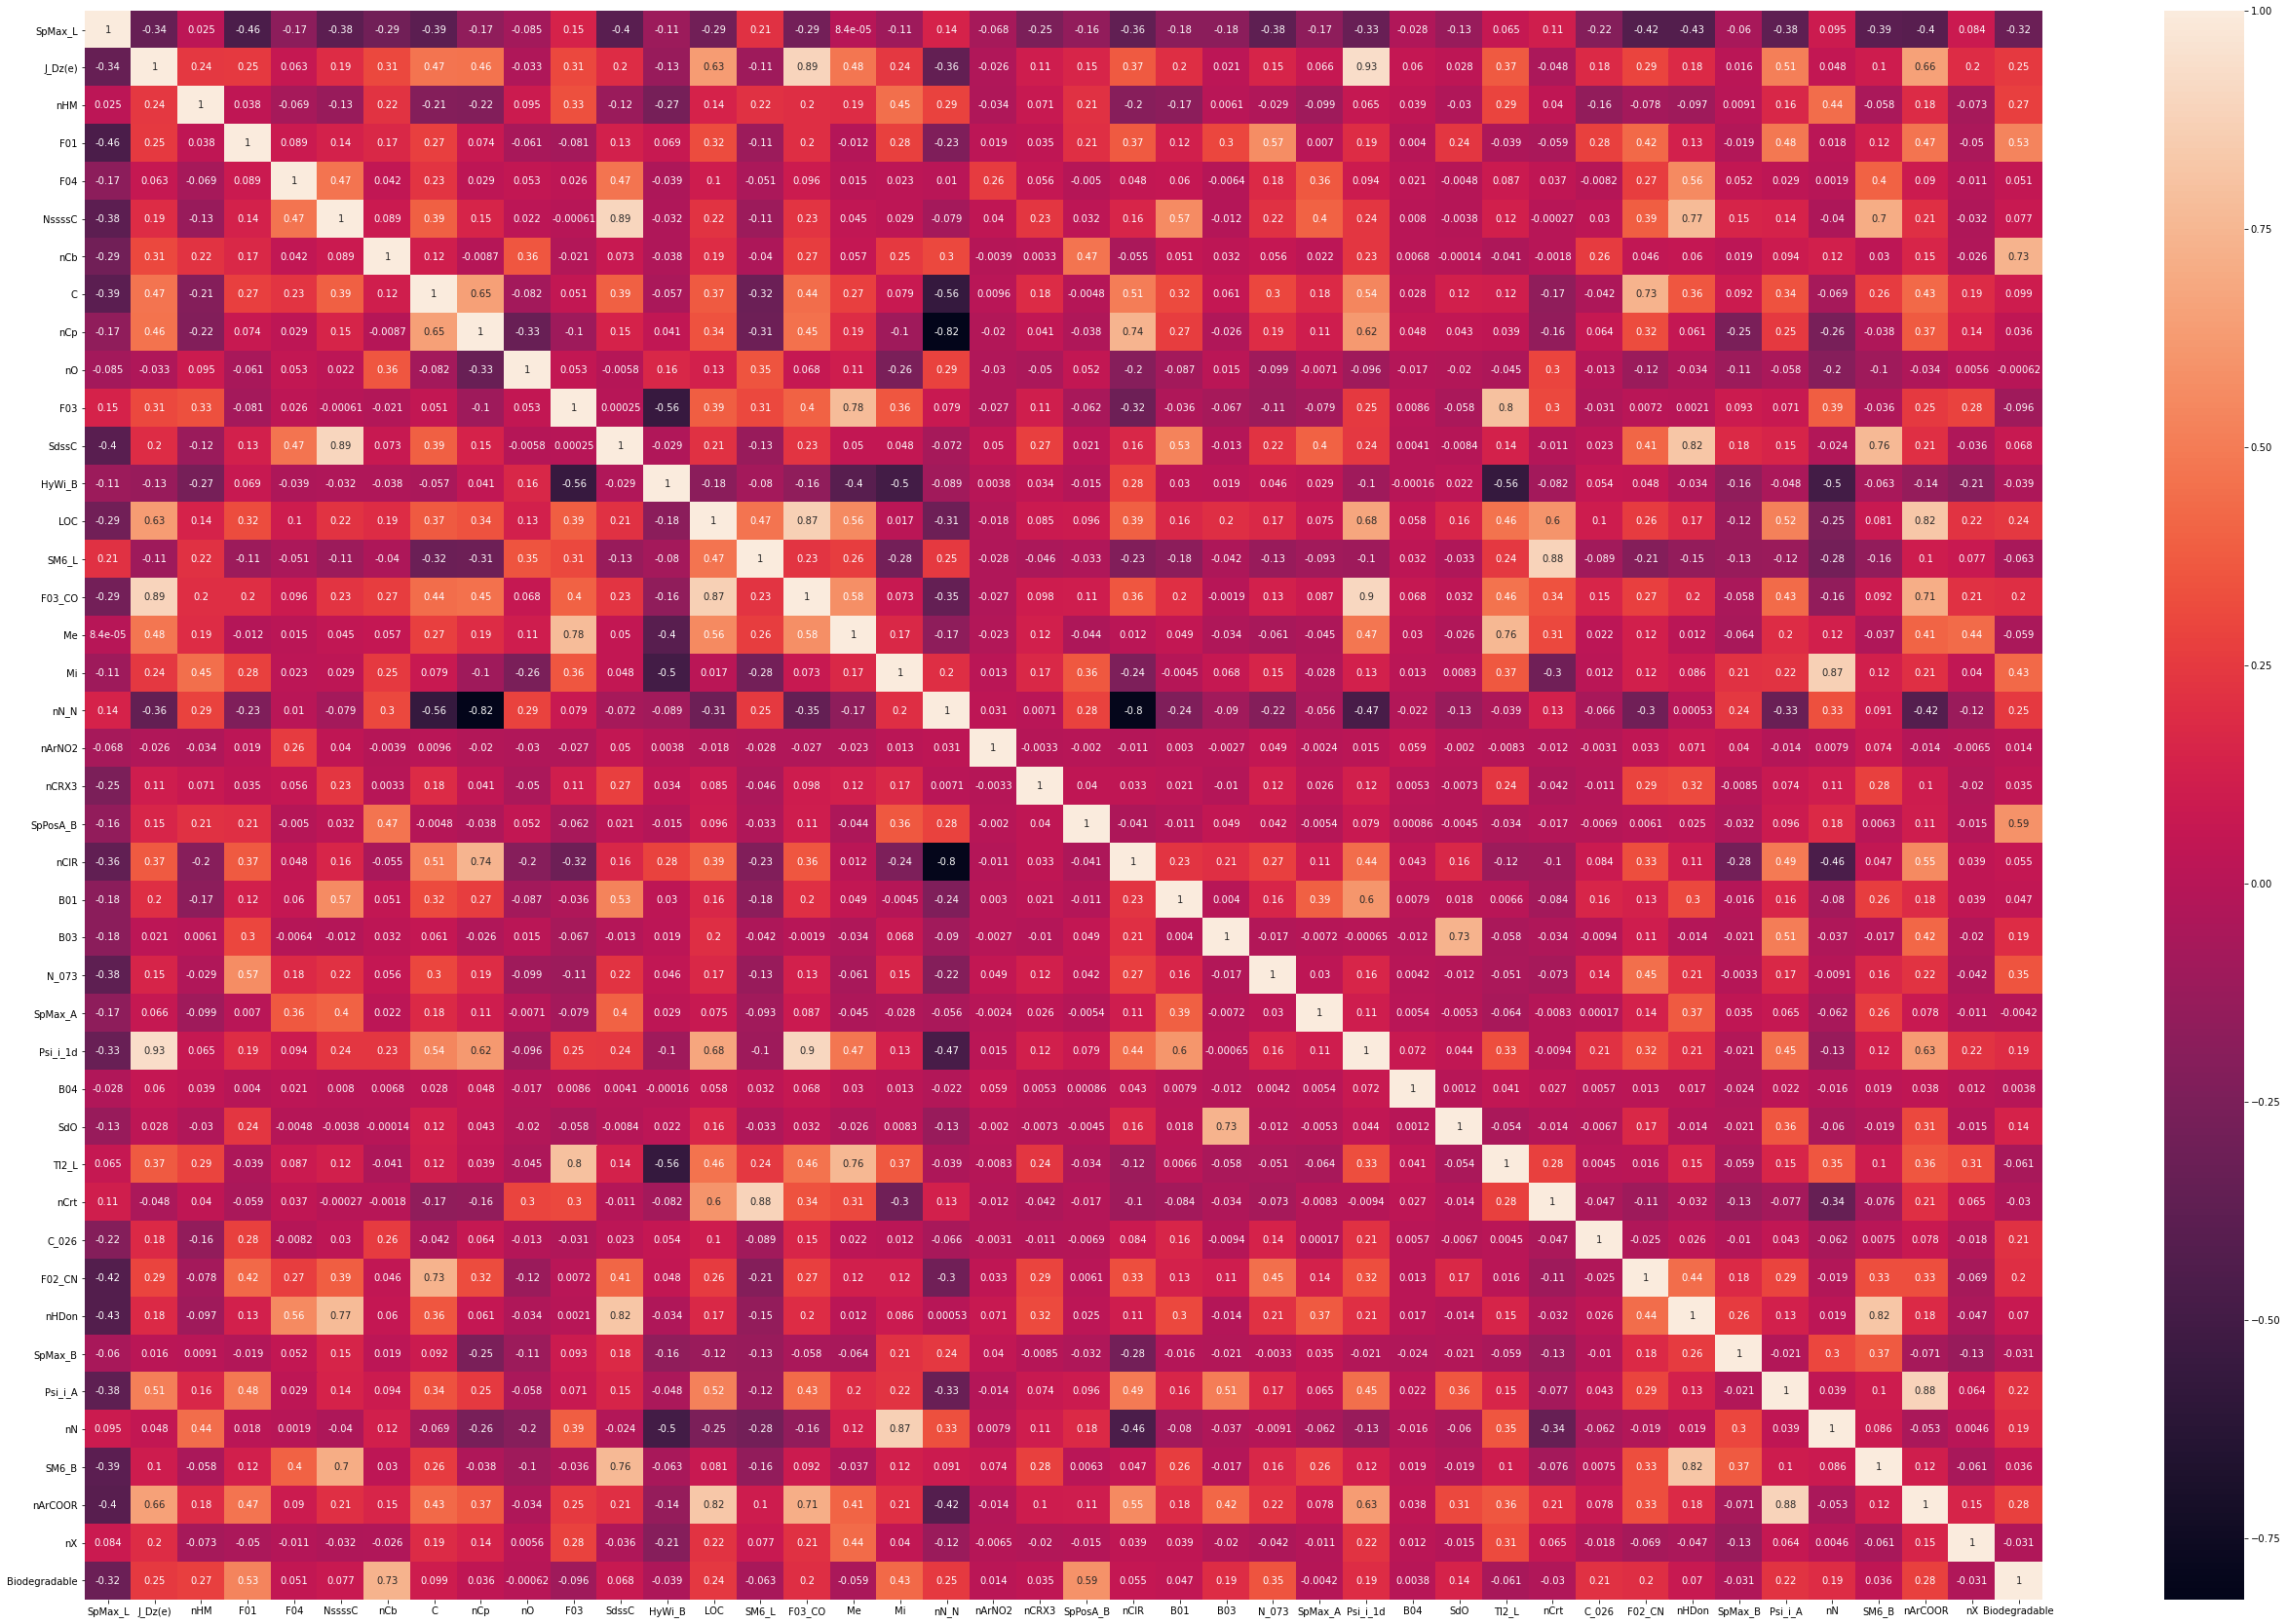

In [11]:
plt.figure(figsize = (45,30))
sns.heatmap(d.corr(method='pearson'), annot = True)
plt.show()

In [12]:
def naif_model_testing(X_train, X_test, y_train, y_test):
    #test 3 approaches and print out the results
    
    rfr= RandomForestClassifier(n_estimators=100)
    rfr.fit(X_train, y_train)

    dtr= DecisionTreeClassifier(max_depth=3)
    dtr.fit(X_train, y_train)

    rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(X_test)

    print("Accuracy RFs: %7.4f" % accuracy_score(y_test, rf_preds))
    print("Matthews Cor. RFs: %7.4f" % matthews_corrcoef(y_test, rf_preds))

    print("Accuracy DTs: %7.4f" % accuracy_score(y_test, dt_preds))
    print("Matthews Cor. DTs: %7.4f" % matthews_corrcoef(y_test, dt_preds))


### 1.4.1 Stepwise Feature Selection

#### 1.4.1.1 Forward


It is bout testing each feature separately and adding the five with the best performance to the model. We choose the top five variables from the other ones that are accessible using the new model. Until there are no more variables or no more expansion of the model is feasible, this process is repeated.

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector

N,M=X_train.shape

#using linear regression for sequential feature selection
dtc=DecisionTreeClassifier(max_depth=3)
sfs = SequentialFeatureSelector(dtc, n_features_to_select=5)
sfs.fit(X_train_cat, y_train)

#get the relevant columns
features=sfs.get_support()
Features_selected =X_train.columns[features]
print("The features selected are columns: ", Features_selected)

nX_train_forward=sfs.transform(X_train_cat)
nX_test_forward=sfs.transform(X_test_cat)

naif_model_testing(nX_train_forward, nX_test_forward, y_train, y_test)

The features selected are columns:  Index(['nHM', 'NssssC', 'nO', 'F03', 'nHDon'], dtype='object')
Accuracy RFs:  0.9422
Matthews Cor. RFs:  0.7852
Accuracy DTs:  0.9343
Matthews Cor. DTs:  0.7536


#### 1.4.1.2 Backward 

Starting with the complete model, we gradually delete each feature from the existing model. We check to see if the new, simplified model performs better, and if so, we go through the process of successively removing each feature from the original model once again, doing so until just the final five features are left.

In [14]:
N,M=X_train.shape

#using linear regression for sequential feature selection
dtc=DecisionTreeClassifier(max_depth=3)
sfs = SequentialFeatureSelector(dtc, n_features_to_select=5, direction='backward')
sfs.fit(X_train_cat, y_train)

#get the relevant columns
features=sfs.get_support()
Features_selected =X_train.columns[features]
print("The features selected are columns: ", Features_selected)

nX_train_backward=sfs.transform(X_train_cat)
nX_test_backward=sfs.transform(X_test_cat)

naif_model_testing(nX_train_backward, nX_test_backward, y_train, y_test)

The features selected are columns:  Index(['nHM', 'NssssC', 'F03', 'nHDon', 'nX'], dtype='object')
Accuracy RFs:  0.9334
Matthews Cor. RFs:  0.7518
Accuracy DTs:  0.9290
Matthews Cor. DTs:  0.7311


### 1.4.2 Random Forest
We list the top 5 features and demonstrate their significance. The features were chosen in this way.

In [15]:
from sklearn.feature_selection import SelectFromModel
rfr=RandomForestClassifier(random_state=0)
sel = SelectFromModel(estimator=rfr,max_features=5)
sel.fit(X_train_cat, y_train)

print("Default threshold: ", sel.threshold_)

features=sfs.get_support()
Features_selected =X_train.columns[features]
print("The features selected are columns: ", Features_selected)

Default threshold:  0.024390243902439025
The features selected are columns:  Index(['nHM', 'NssssC', 'F03', 'nHDon', 'nX'], dtype='object')


In [16]:
nX_train_random=sel.transform(X_train_cat)
nX_test_random=sel.transform(X_test_cat)
naif_model_testing(nX_train_random, nX_test_random, y_train, y_test)

Accuracy RFs:  0.9413
Matthews Cor. RFs:  0.7822
Accuracy DTs:  0.9202
Matthews Cor. DTs:  0.6950


<a id='section6'></a>
## 2. Best Classifiers
- Every model was fitted with data coming from the different feature selection methods.
- We did several iteration to run the models with different features, the most relevant.

 - 1. Is regarding every features
 - 2. The second for the Forward Selection 
 - 3. The third one for the Backward and the last one for the Random Forest
 - 4. The forth is for the top 5 features more correlated with Biodegradable

### 2.1 Gaussian Naive Bayes

In [17]:
def evaluate(y_test, preds):
    print("Accuracy: %7.4f" % accuracy_score(y_test, preds))
    print("MCC: %7.4f" % matthews_corrcoef(y_test, preds))
    print("Prc: %7.4f" % precision_score(y_test, preds))
    print("Rec: %7.4f" % recall_score(y_test, preds))
    print("F1 : %7.4f" % f1_score(y_test, preds))
    print()

In [18]:
X_train_cat_2= X_train_cat.copy()
X_test_cat_2= X_test_cat.copy()
X_train_cat_2.columns = X_columns
X_test_cat_2.columns = X_columns
X_train_cor=X_train_cat_2[['F01','nCb','Mi','SpPosA_B','N_073']]
X_test_cor=X_test_cat_2[['F01','nCb','Mi','SpPosA_B','N_073']]

In [19]:
a=[X_train_cat,nX_train_backward,nX_train_forward,nX_train_random,X_train_cor]
b=[X_test_cat,nX_test_backward,nX_test_forward,nX_test_random,X_test_cor]

for i,j in zip(a,b):
    mdl = GaussianNB()
    mdl.fit(i,y_train)
    preds=mdl.predict(j)
    evaluate(y_test, preds)

Accuracy:  0.9378
MCC:  0.7678
Prc:  0.9433
Rec:  0.9841
F1 :  0.9633

Accuracy:  0.9360
MCC:  0.7617
Prc:  0.9440
Rec:  0.9810
F1 :  0.9622

Accuracy:  0.9378
MCC:  0.7707
Prc:  0.9496
Rec:  0.9767
F1 :  0.9630

Accuracy:  0.9299
MCC:  0.7469
Prc:  0.9520
Rec:  0.9641
F1 :  0.9580

Accuracy:  0.8475
MCC:  0.2993
Prc:  0.8453
Rec:  0.9989
F1 :  0.9157



### 2.2. Random Forests (Bagging)

In [20]:
for i,j in zip(a,b):
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(i, y_train)
    preds=rf.predict(j)
    evaluate(y_test,preds)

Accuracy:  0.9737
MCC:  0.9056
Prc:  0.9781
Rec:  0.9905
F1 :  0.9842

Accuracy:  0.9351
MCC:  0.7578
Prc:  0.9422
Rec:  0.9820
F1 :  0.9617

Accuracy:  0.9439
MCC:  0.7916
Prc:  0.9464
Rec:  0.9884
F1 :  0.9669

Accuracy:  0.9413
MCC:  0.7822
Prc:  0.9480
Rec:  0.9831
F1 :  0.9652

Accuracy:  0.8764
MCC:  0.4986
Prc:  0.8904
Rec:  0.9704
F1 :  0.9287



### 2.3 AdaBoost

In [21]:
for i,j in zip(a,b):
    abc = AdaBoostClassifier(n_estimators=10)
    abc.fit(i, y_train)
    preds=abc.predict(j)
    evaluate(y_test,preds)

Accuracy:  0.9474
MCC:  0.8054
Prc:  0.9502
Rec:  0.9884
F1 :  0.9689

Accuracy:  0.9378
MCC:  0.7684
Prc:  0.9451
Rec:  0.9820
F1 :  0.9632

Accuracy:  0.9369
MCC:  0.7640
Prc:  0.9414
Rec:  0.9852
F1 :  0.9628

Accuracy:  0.9387
MCC:  0.7705
Prc:  0.9371
Rec:  0.9926
F1 :  0.9641

Accuracy:  0.8782
MCC:  0.4998
Prc:  0.8861
Rec:  0.9789
F1 :  0.9302



### 2.4 Gradient boosting

In [22]:
for i,j in zip(a,b):
    gbc = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, random_state=0)
    gbc.fit(i, y_train)
    preds=gbc.predict(j)
    evaluate(y_test,preds)

Accuracy:  0.9579
MCC:  0.8473
Prc:  0.9658
Rec:  0.9841
F1 :  0.9749

Accuracy:  0.9351
MCC:  0.7574
Prc:  0.9413
Rec:  0.9831
F1 :  0.9617

Accuracy:  0.9448
MCC:  0.7954
Prc:  0.9491
Rec:  0.9863
F1 :  0.9673

Accuracy:  0.9422
MCC:  0.7900
Prc:  0.9574
Rec:  0.9736
F1 :  0.9654

Accuracy:  0.8773
MCC:  0.5009
Prc:  0.8897
Rec:  0.9725
F1 :  0.9293



### 2.5 XGBoost

In [23]:
!pip install xgboost

In [24]:
X_train_scaled_imputed.columns=X_columns
X_test_scaled_imputed.columns=X_columns

In [25]:
X_train_back = X_train_scaled_imputed[['nHM', 'NssssC', 'F03', 'nHDon', 'nX']]
X_test_back =  X_test_scaled_imputed[['nHM', 'NssssC', 'F03', 'nHDon', 'nX']]
X_train_for =  X_train_scaled_imputed[['nHM', 'NssssC', 'nO', 'F03', 'nHDon']]
X_test_for =  X_test_scaled_imputed[['nHM', 'NssssC', 'nO', 'F03', 'nHDon']]
X_train_cor = X_train_scaled_imputed[['F01','nCb','Mi','SpPosA_B','N_073']]
X_test_cor = X_test_scaled_imputed[['F01','nCb','Mi','SpPosA_B','N_073']]


a_num = [X_train_scaled_imputed,X_train_back,X_train_for, X_train_cor]
b_num = [X_test_scaled_imputed,X_test_back,X_test_for, X_test_cor]

In [26]:
from xgboost import XGBClassifier
for i,j in zip(a_num,b_num):
    bst = XGBClassifier()
    bst.fit(i, y_train)
    preds=bst.predict(j)
    evaluate(y_test,preds)

Accuracy:  0.9711
MCC:  0.8959
Prc:  0.9760
Rec:  0.9894
F1 :  0.9827

Accuracy:  0.9334
MCC:  0.7518
Prc:  0.9430
Rec:  0.9789
F1 :  0.9606

Accuracy:  0.9448
MCC:  0.7950
Prc:  0.9464
Rec:  0.9894
F1 :  0.9674

Accuracy:  0.9194
MCC:  0.6922
Prc:  0.9261
Rec:  0.9810
F1 :  0.9528



### 2.6 Support Vector Machine

In [27]:
for i,j in zip(a,b):
    clf = svm.SVC()
    clf.fit(i, y_train)
    preds = clf.predict(j)
    evaluate(y_test,preds)

Accuracy:  0.9588
MCC:  0.8493
Prc:  0.9601
Rec:  0.9915
F1 :  0.9756

Accuracy:  0.9343
MCC:  0.7528
Prc:  0.9359
Rec:  0.9884
F1 :  0.9614

Accuracy:  0.9378
MCC:  0.7670
Prc:  0.9388
Rec:  0.9894
F1 :  0.9635

Accuracy:  0.9413
MCC:  0.7819
Prc:  0.9471
Rec:  0.9841
F1 :  0.9653

Accuracy:  0.8773
MCC:  0.5054
Prc:  0.8928
Rec:  0.9683
F1 :  0.9290



### 2.7 Decision Trees

In [28]:
for i,j in zip(a,b):
    mdl = DecisionTreeClassifier(min_samples_leaf=1)
    mdl.fit(i, y_train)
    preds = mdl.predict(j)
    evaluate(y_test,preds)

Accuracy:  0.9281
MCC:  0.7518
Prc:  0.9615
Rec:  0.9514
F1 :  0.9564

Accuracy:  0.9325
MCC:  0.7482
Prc:  0.9420
Rec:  0.9789
F1 :  0.9601

Accuracy:  0.9387
MCC:  0.7714
Prc:  0.9442
Rec:  0.9841
F1 :  0.9638

Accuracy:  0.9404
MCC:  0.7787
Prc:  0.9470
Rec:  0.9831
F1 :  0.9647

Accuracy:  0.8764
MCC:  0.4986
Prc:  0.8904
Rec:  0.9704
F1 :  0.9287



<a id='section7'></a>
## 3. Discussion of Results

The features selection presented good results for all methods tested. Since few features were selected, the statistics results were similar between models. The model with best scores was random forest, with forward feature selection, since it has higher values of accuracy and MCC. According to Occam's razor it is preferable to find an explanation with a simpler model instead of a more complex one. In other words, this was a non surprising result.
We have used different hyperparameters while fitting our data to the random forest model, namely, the “max depth” and the “min samples depth”. It is also important to remark that the data obtained in table 1 is for the best selection methods, as well as for the best hyperparameters.
The random forests are the most common bootstrap aggregation, also known as bagging, and typically give better results, this happens because the variance is reduced, however the distortion is not getting higher. They are very versatile for handling different types of problems (learning problems). The several sets of trees are independent and that could be a reason for the overall better performance of the model. 
On the other hand they are not that stable, and not updatable either. Once new data may change the probabilities of each factor, the remaining forest can be, then, altered.
